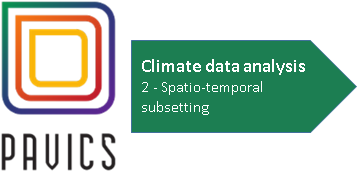

In this second tutorial we will demonstate PAVICS subsetting tools, again accessing Ouranos' cb-oura-1.0 ensemble.  PAVICS subsetting relies on the `clisops` library enabling data extraction by:
* Point location(s) 
* Bounding box 
* Polygon
* Time range

*NOTE : to run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*
___
*Further documentation for python libraries used in this tutorial:<br />*
**clisops** https://clisops.readthedocs.io/en/latest/notebooks/core_subset.html<br />
**geopandas** https://geopandas.org/
___

#### Tutorial preparation steps:
We re-use part of the data-access tutorial to create a list of the cb-oura-1.0 datasets from the PAVICS THREDDS server

'Successfully found 11 datasets for rcp45'

'Successfully found 11 datasets for rcp85'

,Array,Chunk
Bytes,164.20 GB,59.96 MB
Shape,"(55115, 700, 1064)","(322, 175, 266)"
Count,2753 Tasks,2752 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,164.20 GB,59.96 MB
Shape,"(55115, 700, 1064)","(322, 175, 266)"
Count,2753 Tasks,2752 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


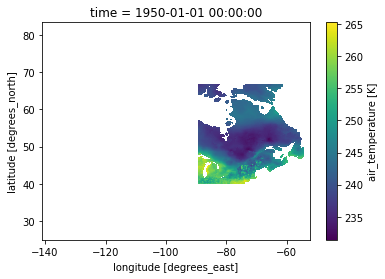

In [36]:
import threddsclient
import xarray as xr
from IPython.display import display
# cb-oura-1.0 thredds catalog url
url = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.html'

#create a simple search sub-function
def get_ncfilelist(pattern, expected, url):
    
    ## crawl a thredds catalog and filter results for dataset names containing a string pattern 
    
    datasets = [ds for ds in threddsclient.crawl(url)]   # list of all datasets 
    ncfiles = [ds for ds in datasets if pattern in ds.name]  # filter 
       
    ## Validate that the number of results is equal to the provided expected number
    if len(ncfiles) == expected:
        display(f"Successfully found {expected} datasets for {pattern}")
        return ncfiles
    else:
        raise ValueError(f'Expected number of datasets for {pattern} is {expected} : found {len(ncfiles)}')

# call the sub-function in a loop searching for RCP 4.5 and 8.5 datasets
datasets = {}
for r in ['rcp45','rcp85']:
    expected = 11
    datasets[r] = get_ncfilelist(r, expected, url)

# create a single datasets for the subsetting demo
ds = xr.open_dataset(datasets['rcp45'][0].opendap_url(), chunks='auto')
display(ds)
ds.tasmin.isel(time=0).plot()

___
### Subsetting point location(s) : `subset_gridpoint`

#### a. Extract the closest gridcell

,Array,Chunk
Bytes,220.46 kB,1.29 kB
Shape,"(55115,)","(322,)"
Count,3441 Tasks,172 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,220.46 kB,1.29 kB
Shape,"(55115,)","(322,)"
Count,3441 Tasks,172 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


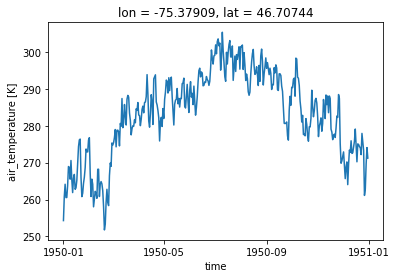

In [37]:
#import subset module 
from clisops.core import subset
ds_gridpoint = subset.subset_gridpoint(ds, lon=-75.4, lat =46.67)
ds_gridpoint
display(ds_gridpoint)
# plot first year of tasmax data
ds_gridpoint.tasmax.isel(time=slice(0,365)).plot()

#### b. Extract multiple locations
* Multiple locations can be extracted by sending in a list of latitude and longitude values
* The output will include a new `site` dimension

,Array,Chunk
Bytes,661.38 kB,3.86 kB
Shape,"(55115, 3)","(322, 3)"
Count,3441 Tasks,172 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,661.38 kB,3.86 kB
Shape,"(55115, 3)","(322, 3)"
Count,3441 Tasks,172 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


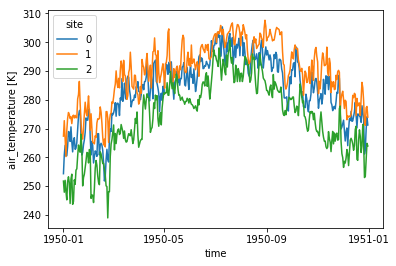

In [38]:
lon=[-75.4, -85, -65.5]
lat=[46.67, 41, 55.3]
ds_gridpoint = subset.subset_gridpoint(ds, lon=lon, lat=lat)
display(ds_gridpoint)
# plot first year of tasmax data
ds_gridpoint.tasmax.isel(time=slice(0,365)).plot.line(x='time')

#### c. Add a distance coordinate
* As `subset_gridpoint`extracts the closest gridcell to the provided locaiton (based on grid centroid coordinates) it can sometimes be useful to add a distance coordinate to the output by using the `add_distance` parameter. This additonal coordinate indicates the distance (m) between the provided point location and the selected gridcell's centroid 

In [39]:
ds_gridpoint = subset.subset_gridpoint(ds, lon=lon, lat =lat, add_distance=True)
for s in ds_gridpoint.site:
    print(f"lon, lat, distance : {ds_gridpoint.sel(site=s).lon.values},{ds_gridpoint.sel(site=s).lat.values}, {ds_gridpoint.sel(site=s).distance.values}" )
    

lon, lat, distance : -75.37908935546875,46.70743942260742, 4458.753289441962
lon, lat, distance : -84.96204376220703,41.04100036621094, 5560.941971821458
lon, lat, distance : -65.46282196044922,55.290428161621094, 2590.9583935390424


<br />

___
### Subsetting using a boundary box : `subset_bbox`
#### a. Extract data using latitude and longitude bounds


,Array,Chunk
Bytes,7.10 GB,27.18 MB
Shape,"(55115, 132, 244)","(322, 122, 173)"
Count,4817 Tasks,688 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.10 GB,27.18 MB
Shape,"(55115, 132, 244)","(322, 122, 173)"
Count,4817 Tasks,688 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


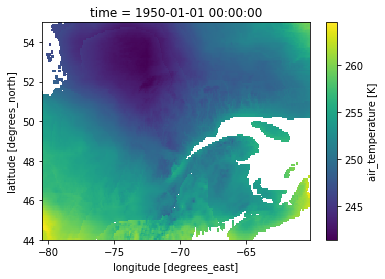

In [40]:
lon_bnds = [-80.5, -60.2]
lat_bnds = [44, 55]

ds1 = subset.subset_bbox(ds, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
display(ds1)
#plot a map of first timestep
ds1.tasmax.isel(time=0).plot()

___
### Subsetting using a polygon : `subset_shape`

*Preparation : We will use a geojson polygon layer for Quebec administative regions as a test layer. User's can also upload their own polygon layers (geojson, .shp or other)to their writable-workspace*

,isSubreg,AreaKm2,Region,Stride,RegType,geometry
0,1,64619.543075,Abitibi-Témiscamingue,1,admin,"MULTIPOLYGON (((-75.52055 49.00002, -75.52064 ..."
1,1,19429.113878,Capitale-Nationale,1,admin,"MULTIPOLYGON (((-70.78151 46.97156, -70.80159 ..."
2,1,7035.163146,Centre-du-Québec,1,admin,"MULTIPOLYGON (((-72.03655 46.55848, -72.03607 ..."
3,1,15267.682927,Chaudière-Appalaches,1,admin,"MULTIPOLYGON (((-70.64336 47.02725, -70.64995 ..."
4,1,10502.393578,Estrie,1,admin,"MULTIPOLYGON (((-70.41361 45.79600, -70.41368 ..."


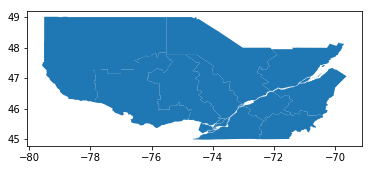

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
regions = gpd.GeoDataFrame.from_file('test_regions.geojson')
display(regions.head())
regions.plot()

#### a. Extracting data using a polygon layer
The simplest method of using `subset_shape` is to simply provide polygon layer filepath as input 

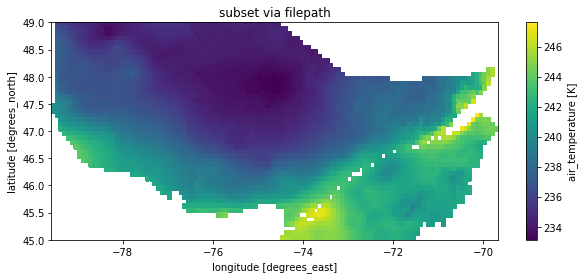

In [42]:
ds_poly = subset.subset_shape(ds, shape='test_regions.geojson') #use path to layer
plt.figure(figsize=(10, 4)) 
ds_poly.tasmin.isel(time=0).plot()
plt.title('subset via filepath')
display()

___
### Subsetting time

#### a. Temporal subsetting can be applied to existing datasets by directly calling `subset_time` providing a `start_date` and/or `end_date` parameter
* Parameters are given in a date string format – can be year “%Y”, year-month “%Y-%m” or year-month-day “%Y-%m-%d”

In [43]:
# remove data previous to a date : 
ds_sub = subset.subset_time(ds, start_date='1981')
print('Subset time using start_date only ... \nmin time : ', ds_sub.time.min().values, '; max time : ', ds_sub.time.max().values  )

# remove data after a date : 
ds_sub = subset.subset_time(ds, end_date='2070-08')
print('\nSubset time using end_date only ... \nmin time : ', ds_sub.time.min().values, '; max time : ', ds_sub.time.max().values  )

# Select a temporal slice 
ds_sub = subset.subset_time(ds, start_date='1981-08-05', end_date='2084-06-15')
print('\nSubset time using both start_date & end_date  ... \nmin time : ', ds_sub.time.min().values, '; max time : ', ds_sub.time.max().values  )

Subset time using start_date only ... 
min time :  1981-01-01 00:00:00 ; max time :  2100-12-31 00:00:00

Subset time using end_date only ... 
min time :  1950-01-01 00:00:00 ; max time :  2070-08-31 00:00:00

Subset time using both start_date & end_date  ... 
min time :  1981-08-05 00:00:00 ; max time :  2084-06-15 00:00:00


#### b. Spatio-Temporal selection in a sinlge step 
* Provide subset_time date string parameters directly to spatial subset functions 

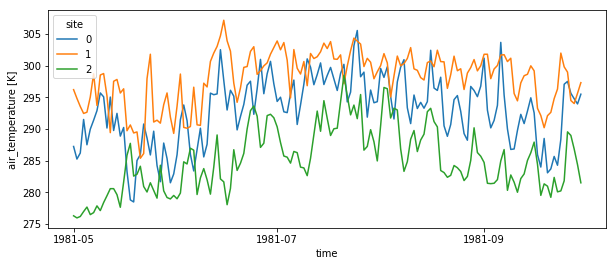

In [44]:
start_date = '1981-05'
end_date = '1981-09'
lon=[-75.4, -85, -65.5]
lat=[46.67, 41, 55.3]
ds_gridpoint = subset.subset_gridpoint(ds, lon= lon, lat=lat, start_date=start_date, end_date=end_date)
ds_gridpoint.tasmax.plot.line(figsize=(10,4),x='time')
display()

___
### Advanced subsetting topics
#### a. Extracting data using a `geopandas.GeoDataFrame`
In some when using `subset_shape` it can be useful to manipulate a polygon layer before subsetting. For example subsetting using a polygon layer with non geographic coordinates (latitude/longitude) will result in an error. By loading the layer first as a geodataframe we can change the projection on the fly using`to_crs()`

There was a problemn... the polygon layer projection is NAD83 / Canada Atlas Lambert
try projecting to WGS 84
success


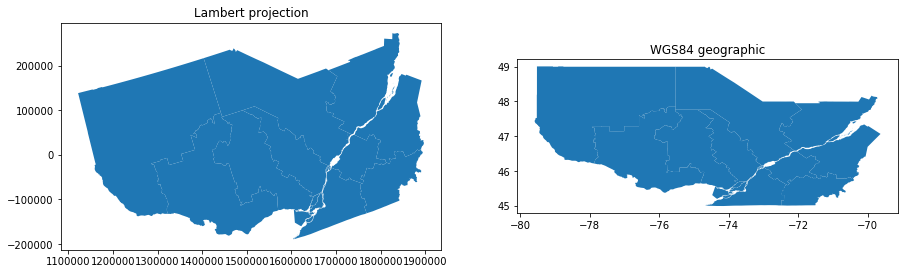

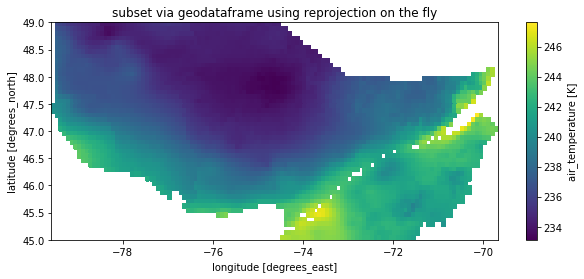

In [45]:
# Demo lambert project polygon layer
regions_lcc= gpd.GeoDataFrame.from_file('test_regions_lambert.geojson')
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1,2,1)
regions_lcc.plot(ax=ax1)
plt.title('Lambert projection')
ax2 = plt.subplot(1,2,2)
regions_lcc.to_crs(epsg=4326).plot(ax=ax2)
plt.title('WGS84 geographic')
display()
try :
    ds_poly = subset.subset_shape(ds, regions_lcc)
except:
    print(f'There was a problemn... the polygon layer projection is {regions_lcc.crs.name}\ntry projecting to WGS 84')
    ds_poly =  subset.subset_shape(ds, regions_lcc.to_crs(epsg=4326))
    
plt.figure(figsize=(10, 4)) 
ds_poly.tasmin.isel(time=0).plot()
plt.title('subset via geodataframe using reprojection on the fly')
display()
print('success')

We may also wish to subset the climate data using a selection of available polygons
* for example use only the Montérégie and Outaouais subregions

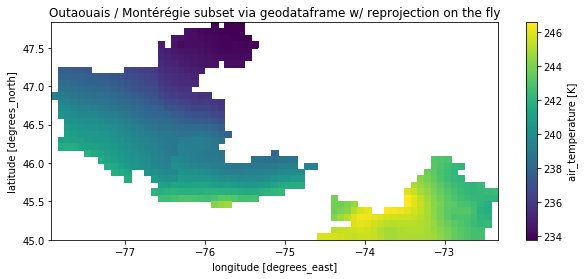

In [46]:
subreg = regions_lcc.loc[(regions_lcc['Region'] == 'Outaouais') | (regions_lcc['Region'] == 'Montérégie')]
ds_poly1 =  subset.subset_shape(ds, subreg.to_crs(epsg=4326))
    
plt.figure(figsize=(10, 4)) 
ds_poly1.tasmin.isel(time=0).plot()
plt.title('Outaouais / Montérégie subset via geodataframe w/ reprojection on the fly')
display()

#### b. Creating a sub-region mask
In some cases ... ADDTEXT


Text(0.5, 1.0, 'Mask of regions')

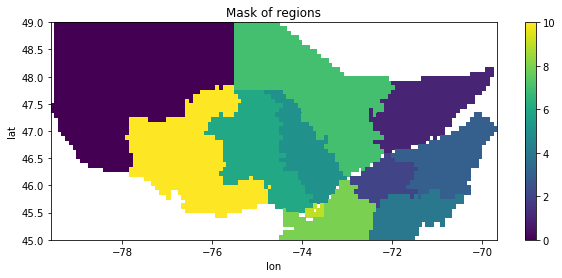

In [47]:
mask = subset.create_mask_vectorize(x_dim = ds_poly.lon, y_dim=ds_poly.lat, poly=regions).transpose()
mask.plot(figsize=(10,4))
plt.title('Mask of regions')

Assign region coordinates 

In [55]:
ds_poly = ds_poly.assign_coords(region_id=mask)
display(ds_poly.region_id.values)

# create region_name coordinates
name_array = xr.full_like(ds_poly.region_id, '', dtype=object)
name_field = 'Region'
for i, name in enumerate(regions[name_field]):
    
    name_array = xr.where(ds_poly['region_id'] == i, name, name_array)
    ds_poly = ds_poly.assign_coords(region_name=name_array)
ds_poly.region_name.values

array([[nan,  0.,  0., ..., nan, nan, nan],
       [nan,  0.,  0., ..., nan, nan, nan],
       [nan,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

array([['', 'Abitibi-Témiscamingue', 'Abitibi-Témiscamingue', ..., '',
        '', ''],
       ['', 'Abitibi-Témiscamingue', 'Abitibi-Témiscamingue', ..., '',
        '', ''],
       ['', 'Abitibi-Témiscamingue', 'Abitibi-Témiscamingue', ..., '',
        '', ''],
       ...,
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', '']], dtype=object)

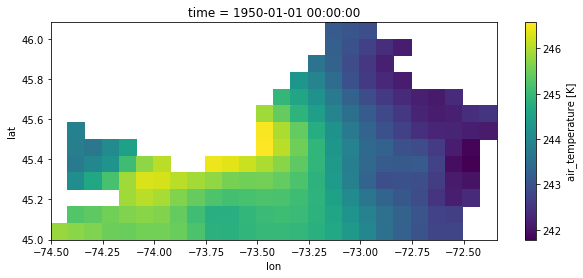

In [58]:
ds_poly.where(ds_poly.region_name=='Montérégie', drop=True).tasmin.isel(time=0).plot(figsize=(10,4))

In [64]:
# Summarize by region using groupby
ds_poly.groupby(ds_poly.region_name).mean(keep_attrs=True)

,Array,Chunk
Bytes,2.65 MB,1.29 kB
Shape,"(12, 55115)","(1, 322)"
Count,18926 Tasks,2064 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.65 MB,1.29 kB
Shape,"(12, 55115)","(1, 322)"
Count,18926 Tasks,2064 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


,Array,Chunk
Bytes,1.26 GB,3.71 MB
Shape,"(55115, 48, 119)","(322, 48, 60)"
Count,4478 Tasks,344 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.26 GB,3.71 MB
Shape,"(55115, 48, 119)","(322, 48, 60)"
Count,4478 Tasks,344 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
